In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import numpy as np

In [2]:
# Code to display progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# Check if GPU avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [4]:
from torch.utils.data import DataLoader
# Initialize dataset
# Using Cifar100
DATA_PATH = "./data"

s_min = 256
s_max = 512
batch_size = 256

q = 224

CIFAR10_TRAIN_MEAN = (0.5,0.5,0.5)#[0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
CIFAR10_TRAIN_STD = (0.5,0.5,0.5)#[0.2673342858792401, 0.2564384629170883, 0.27615047132568404]

def augmentHorizontalFlip(image):
    return (image, transforms.functional.hflip(image))

def stackToTensor(images):
    return torch.stack([transforms.ToTensor()(image) for image in images])
    
def stackNormalize(images):
    return torch.stack([transforms.Normalize(mean=CIFAR10_TRAIN_MEAN, std=CIFAR10_TRAIN_STD)(image) for image in images])
    
    
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_TRAIN_MEAN, std=CIFAR10_TRAIN_STD),
    # TODO: add Fancy PCA in https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
    # https://pixelatedbrian.github.io/2018-04-29-fancy_pca/
    
])
test_transform = transforms.Compose([
    transforms.Lambda(augmentHorizontalFlip),
    transforms.Lambda(stackToTensor),
    transforms.Lambda(stackNormalize),
])

train_dataset = datasets.CIFAR10(f"{DATA_PATH}", train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(f"{DATA_PATH}", train=False, transform=test_transform, download=True)

# Train and validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(train_size, val_size, len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


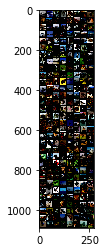

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5  # Un-normalize your image here
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
from vggnet import VGGNet

vggnet = VGGNet("vgg11", num_classes=10).to(device)
optim = torch.optim.Adam(vggnet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optim = torch.optim.Adam(vggnet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=2)

In [ ]:
vggnet

VGGNet(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [ ]:
import os.path

MODEL_PATH = "models/vgg.pth"
if os.path.isfile(MODEL_PATH):
    print("Loading save model")
    if torch.cuda.is_available():
        vggnet.load_state_dict(torch.load(MODEL_PATH))
    else:
        vggnet.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))
    print("Model loaded successfully")
else:
    print("Model not found")

Loading save model
Model loaded successfully


In [ ]:
# Training code

import time
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} ", end="")
    
    for param_group in optim.param_groups:
        print(f"LR = {param_group['lr']} ", end="")
    if epoch % 5 == 4:
        torch.save(vggnet.state_dict(), f"models/vgg.pth")
    
    running_loss = 0.0
    t0 = time.time()
    vggnet.train()
    for i, data in enumerate((train_loader)):
        # Switch to training mode
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optim.zero_grad()
        outputs = vggnet(inputs)
        
        # Backwards propagation
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
    
    
    val_loss = 0.0
    with torch.no_grad():
        vggnet.eval()
        for i,data in enumerate(val_loader):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()
            outputs = vggnet(inputs)
            # Backwards propagation
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        
        prev_val_loss = val_loss
        t1 = time.time()
        time_total = t1-t0
    avg_val_loss = val_loss / (val_size/batch_size)
    avg_training_loss = running_loss / (train_size/batch_size)
    scheduler.step(avg_val_loss)
    print(f"Training Loss: {avg_training_loss}, Validation Loss: {avg_val_loss}, Time Taken: {time_total} ")

        
print("Training concluded")


Epoch 1 LR = 0.01 Training Loss: 1.0660553554534913, Validation Loss: 60844.79318114319, Time Taken: 33.73297667503357 
Epoch 2 LR = 0.01 Training Loss: 1.2747324131011963, Validation Loss: 1.187792530822754, Time Taken: 35.90968036651611 
Epoch 3 LR = 0.01 Training Loss: 1.1053615249633788, Validation Loss: 0.9812660079956055, Time Taken: 34.71999955177307 
Epoch 4 LR = 0.01 Training Loss: 0.991886198425293, Validation Loss: 0.9530680801391601, Time Taken: 34.634029388427734 
Epoch 5 LR = 0.01 Training Loss: 1.045167357635498, Validation Loss: 1.0787330322265625, Time Taken: 34.542996644973755 
Epoch 6 LR = 0.01 Training Loss: 1.0733932174682617, Validation Loss: 1.201576039123535, Time Taken: 34.46459627151489 
Epoch 7 LR = 0.01 Training Loss: 0.9386658794403077, Validation Loss: 7871.887052738953, Time Taken: 34.61903476715088 
Epoch 8 LR = 0.001 Training Loss: 0.8051260204315186, Validation Loss: 1.0822416877746581, Time Taken: 34.76352882385254 
Epoch 9 LR = 0.001 Training Loss: 0

In [ ]:
#TODO: Test model
vggnet.eval()

total = 0
correct = 0
with torch.no_grad():
    for data in log_progress(test_loader):
        inputs, labels = data
        bs, n_img, c, h, w = inputs.size()
        inputs = inputs.view(-1, c, h, w).to(device)
        labels = labels.to(device)
        
        outputs = vggnet(inputs)
        # outputs = torch.mean(outputs, dim=[2,3])
        outputs = outputs.view(bs, n_img, -1).mean(1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))